# Heatmaps

In [1]:
import os
# import nibabel as nib

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import time
import pickle
import random

from scipy import ndimage

# from skimage.filters import threshold_otsu
# from skimage.measure import label, regionprops
# from skimage import transform
# from skimage.transform import resize
# import skimage.exposure as skie

import ot

import torch
from torch import manual_seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
# from torchsummary import summary
import torchvision
from torchvision import datasets, models, transforms

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

import gc 
from PIL import Image 

torch.cuda.is_available()

torch.set_num_threads(3)

SEED = 1234

from captum.attr import IntegratedGradients, Saliency, DeepLift, DeepLiftShap, GradientShap  
from captum.attr import GuidedBackprop, Deconvolution, LRP, InputXGradient, Lime

from captum._utils.models.linear_model import SkLearnLasso
# lime = Lime(net, interpretable_model=SkLearnLasso(alpha=0.0))

# from zennit.composites import EpsilonPlusFlat
from zennit.composites import EpsilonAlpha2Beta1


# device='cuda:6'
device='cpu'
def rescale_values(image,max_val,min_val):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val




C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\clark01\.virt

In [2]:
device='cpu'
DEVICE=device

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5)
        self.conv2=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv3=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=5)
        
        self.maxPooling2=nn.MaxPool2d(kernel_size=2)
        self.maxPooling4_0=nn.MaxPool2d(kernel_size=4)
        self.maxPooling4_1=nn.MaxPool2d(kernel_size=4)
#         self.adPooling=nn.AdaptiveAvgPool1d(256)
        
        self.fc1=nn.Linear(in_features=256,out_features=128)
        self.fc2=nn.Linear(in_features=128,out_features=64)
        self.out=nn.Linear(in_features=64,out_features=2)

    def forward(self,x):
        x=self.conv1(x)
        x=self.maxPooling4_0(x)
        x=F.relu(x)
        
        x=self.conv2(x)
        x=self.maxPooling4_1(x)
        x=F.relu(x)
        
        x=self.conv3(x)
        x=self.maxPooling2(x)
        x=F.relu(x)
        
        x=F.dropout(x)
        x=x.view(1,x.size()[0],-1) #stretch to 1d data
        #x=self.adPooling(x).squeeze()
        
        x=self.fc1(x)
        x=F.relu(x)
        
        x=self.fc2(x)
        x=F.relu(x)
        
        x=self.out(x)
        
        return x[0]


In [4]:
def load_model(path):
    model = Net()
    
    model.load_state_dict(torch.load(path,map_location=device))
    model.eval()
    model.zero_grad()
    
    model.relu=nn.ReLU(inplace=False)
    return model

def load_trained(path):
    model = Net()
    
    model.load_state_dict(torch.load(path,map_location=device))
    model.eval()
    model.zero_grad()
    
    model.relu=nn.ReLU(inplace=False)
    return model


In [5]:
model_confounder=load_model('./cnn_conf_0.pt').to(device)
model_supressor=load_model('./cnn_sup_0.pt').to(device)
model_no_water=load_model('./cnn_no_0.pt').to(device)


In [6]:
with open('mark_all128.pkl', 'rb') as f:
    watermark_dataset = pickle.load(f)
    watermark_dataset = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in watermark_dataset]
print('test')

with open('no_mark_test128.pkl', 'rb') as f:
    no_watermark_dataset = pickle.load(f)
    no_watermark_dataset = [[rescale_values(i[0],1,0).transpose(2,0,1),i[1]] for i in no_watermark_dataset]
print('test')

test
test


(3, 128, 128)
torch.Size([1, 3, 128, 128])


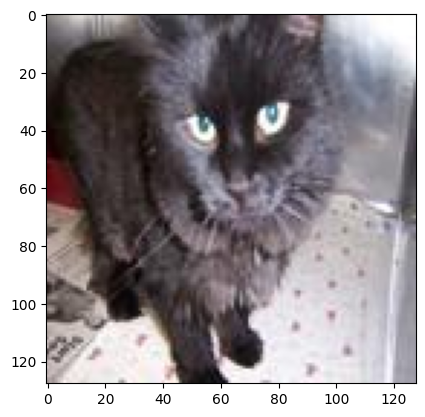

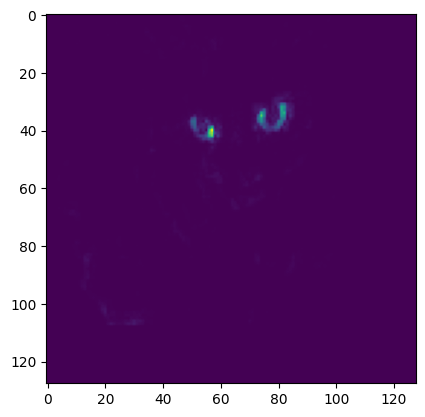

In [7]:
def lrp(data,model,target,device):
    # create a composite instance
    #composite = EpsilonPlusFlat()
    composite = EpsilonAlpha2Beta1()

    # use the following instead to ignore bias for the relevance
    # composite = EpsilonPlusFlat(zero_params='bias')

    # make sure the input requires a gradient
    data.requires_grad = True

    # compute the output and gradient within the composite's context
    with composite.context(model) as modified_model:
        modified_model=modified_model.to(device)
        output = modified_model(data.to(device))
        # gradient/ relevance wrt. class/output 0
        output.backward(gradient=torch.eye(2)[[target]].to(device))
        # relevance is not accumulated in .grad if using torch.autograd.grad
        # relevance, = torch.autograd.grad(output, input, torch.eye(10)[[0])

    # gradient is accumulated in input.grad
    att=abs(data.grad.detach().cpu().squeeze().numpy().transpose(1,2,0))

    rgb_weights = [0.2989, 0.5870, 0.1140]
    grayscale_att_lrp = np.dot(att[...,:3], rgb_weights)

    
    return grayscale_att_lrp
    

n=2
test_img = no_watermark_dataset[n][0]
print(test_img.shape)
target=no_watermark_dataset[n][1]
# test_img = supressor_test[n][0]
# target=supressor_test[n][1]
transformed_img=torch.tensor(test_img)
input_image = transformed_img.unsqueeze(0)
print(input_image.shape)
data=input_image.to(device,dtype=torch.float)

plt.imshow(input_image.squeeze().to('cpu').numpy().transpose(1,2,0))
plt.figure()
grayscale_att_lrp=lrp(data,model_supressor,1,device)
plt.imshow(abs(grayscale_att_lrp))

In [9]:
def plot_atts(data,model,target):
    # data is a tensor of shape torch.Size([1, 3, 128, 128])
    # model is
    # target is an integer
    
    torch.manual_seed(SEED)
    out=model(data)
    Y_probs = F.softmax(out[0], dim=-1)
    
    ig_att = np.transpose(IntegratedGradients(model).attribute(data, target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    sal_att = np.transpose(Saliency(model).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    gradshap_att = np.transpose(GradientShap(model).attribute(data,target=target, baselines=torch.zeros(data.shape).to(device)).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    backprop_att = np.transpose(GuidedBackprop(model).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    ix_att = np.transpose(InputXGradient(model).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    deconv_att = np.transpose(Deconvolution(model).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    lrp_att=np.transpose(LRP(model).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
#     lime_att=np.transpose(Lime(model,interpretable_model=SkLearnLasso(alpha=0.01)).attribute(data,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
    lrp_ab = lrp(data, model, target, DEVICE)
    
    rgb_weights = [0.2989, 0.5870, 0.1140]
    
    grayscale_att_deconv = np.dot(deconv_att[...,:3], rgb_weights)
    grayscale_att_ix = np.dot(ix_att[...,:3], rgb_weights)
    grayscale_att_backprp = np.dot(backprop_att[...,:3], rgb_weights)
    grayscale_att_shap = np.dot(gradshap_att[...,:3], rgb_weights)
    grayscale_att_sal = np.dot(sal_att[...,:3], rgb_weights)
    grayscale_att_ig = np.dot(ig_att[...,:3], rgb_weights)
    grayscale_att_lrp = np.dot(lrp_att[...,:3], rgb_weights)
#     grayscale_att_lime = np.dot(lime_att[...,:3], rgb_weights)
    
    grayscale_att_lime = 0
    
    atts={'deconv':abs(grayscale_att_deconv),'saliency':abs(grayscale_att_sal),'gradients':abs(grayscale_att_ig),
          'shap':abs(grayscale_att_shap),'backprop':abs(grayscale_att_backprp),'ix':abs(grayscale_att_ix),
          'lrp':abs(grayscale_att_lrp), 'lime': abs(grayscale_att_lime), 'lrp-ab': abs(lrp_ab)}
    
    
#     print(grayscale_att_sal.shape)
#     plt.figure(figsize=(20,10))
#     plt.subplot(1,3,1)
#     plt.imshow(test_img.transpose(1,2,0))
#     plt.subplot(1,3,2)
#     plt.imshow(resize(grayscale_att_sal,(128,128)),cmap='inferno')
#     plt.subplot(1,3,3)
#     plt.imshow(test_img.transpose(1,2,0))
#     plt.imshow(resize(grayscale_att_sal,(128,128)),cmap='inferno',alpha=0.7)


    return atts,Y_probs

In [9]:
# def plots(n, device, model_ind=0):
#     #images
#     watermark_image=watermark_dataset[n][0]    
#     data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
#     no_watermark_image=no_watermark_dataset[n][0]
#     data_no_watermark=torch.tensor(no_watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
#     #target (same for both images)
#     target=watermark_dataset[n][1]
    
#     #models
# #     model_conf = model_confounder.to(device)
# #     model_sup = model_supressor.to(device)
# #     model_no = model_no_water.to(device)

#     model_conf=load_trained(f'./cnn_conf_{model_ind}.pt').to(device)
#     model_sup=load_trained(f'./cnn_sup_{model_ind}.pt').to(device)
#     model_no=load_trained(f'./cnn_no_{model_ind}.pt').to(device)
    
#     #plots 
#     fig, axs = plt.subplots(6, 7,figsize=(16, 22))
#     plt.subplots_adjust(wspace=0.05, hspace=0.05)
#     font_size=15
#     plt.rcParams['font.size'] = font_size
#     plt.rc('axes', titlesize=font_size) #title
    
#     atts={'watermark_conf':plot_atts(data_watermark,model_conf,target),
#           'watermark_sup':plot_atts(data_watermark,model_sup,target),
#           'watermark_no':plot_atts(data_watermark,model_no,target),
#           'no_watermark_conf':plot_atts(data_no_watermark,model_conf,target),
#           'no_watermark_sup':plot_atts(data_no_watermark,model_sup,target),
#           'no_watermark_no':plot_atts(data_no_watermark,model_no,target)}
    
    
#     original_imgs=[watermark_image,no_watermark_image,
#                    watermark_image,no_watermark_image,
#                    watermark_image,no_watermark_image]
    
#     images=[atts['watermark_conf'][0],atts['no_watermark_conf'][0],
#             atts['watermark_sup'][0],atts['no_watermark_sup'][0],
#             atts['watermark_no'][0],atts['no_watermark_no'][0]]
    
#     probs=[atts['watermark_conf'][1],atts['no_watermark_conf'][1],
#             atts['watermark_sup'][1],atts['no_watermark_sup'][1],
#             atts['watermark_no'][1],atts['no_watermark_no'][1]]
    
#     labels=['Model Confounder','Model Confounder',
#            'Model Supressor','Model Supressor',
#            'Model No Watermark','Model No Watermark']
    
#     cmap='cubehelix'
#     cmap='hot'
#     cmap='inferno'
#     cmap='CMRmap'

#     for i in range(7):
#         for j in range(6):
#             axs[j,i].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
            
#             axs[j,0].imshow(original_imgs[j].transpose(1,2,0))
#             axs[j,1].imshow(images[j]['deconv'],cmap=cmap)
#             axs[j,2].imshow(images[j]['gradients'],cmap=cmap)
#             axs[j,3].imshow(images[j]['shap'],cmap=cmap)
#             axs[j,4].imshow(images[j]['lrp'],cmap=cmap)
#             axs[j,5].imshow(images[j]['lime'],cmap=cmap)
#             axs[j,6].imshow(images[j]['lrp-ab'],cmap=cmap)
            
#             axs[j,0].set_ylabel(labels[j])
#             if j<5:
#                 axs[j+1,0].title.set_text(f'prob={round(float(probs[j+1][target].cpu().detach().numpy()),3)}')
            
#     axs[0,0].title.set_text(f'original image \n prob={round(float(probs[0][target].cpu().detach().numpy()),3)}')  
#     axs[0,1].title.set_text('Deconv')
#     axs[0,2].title.set_text('Gradients')
#     axs[0,3].title.set_text('Gradient SHAP')
#     axs[0,4].title.set_text('LRP')
#     axs[0,5].title.set_text('LIME')
#     axs[0,6].title.set_text('LRP-ab')
    
    
        
# plots(0,device,1)

C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\captum\_utils\gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\clark01\.virtualenvs\debugging_xai-9luXJGIR\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


TypeError: Invalid shape () for image data

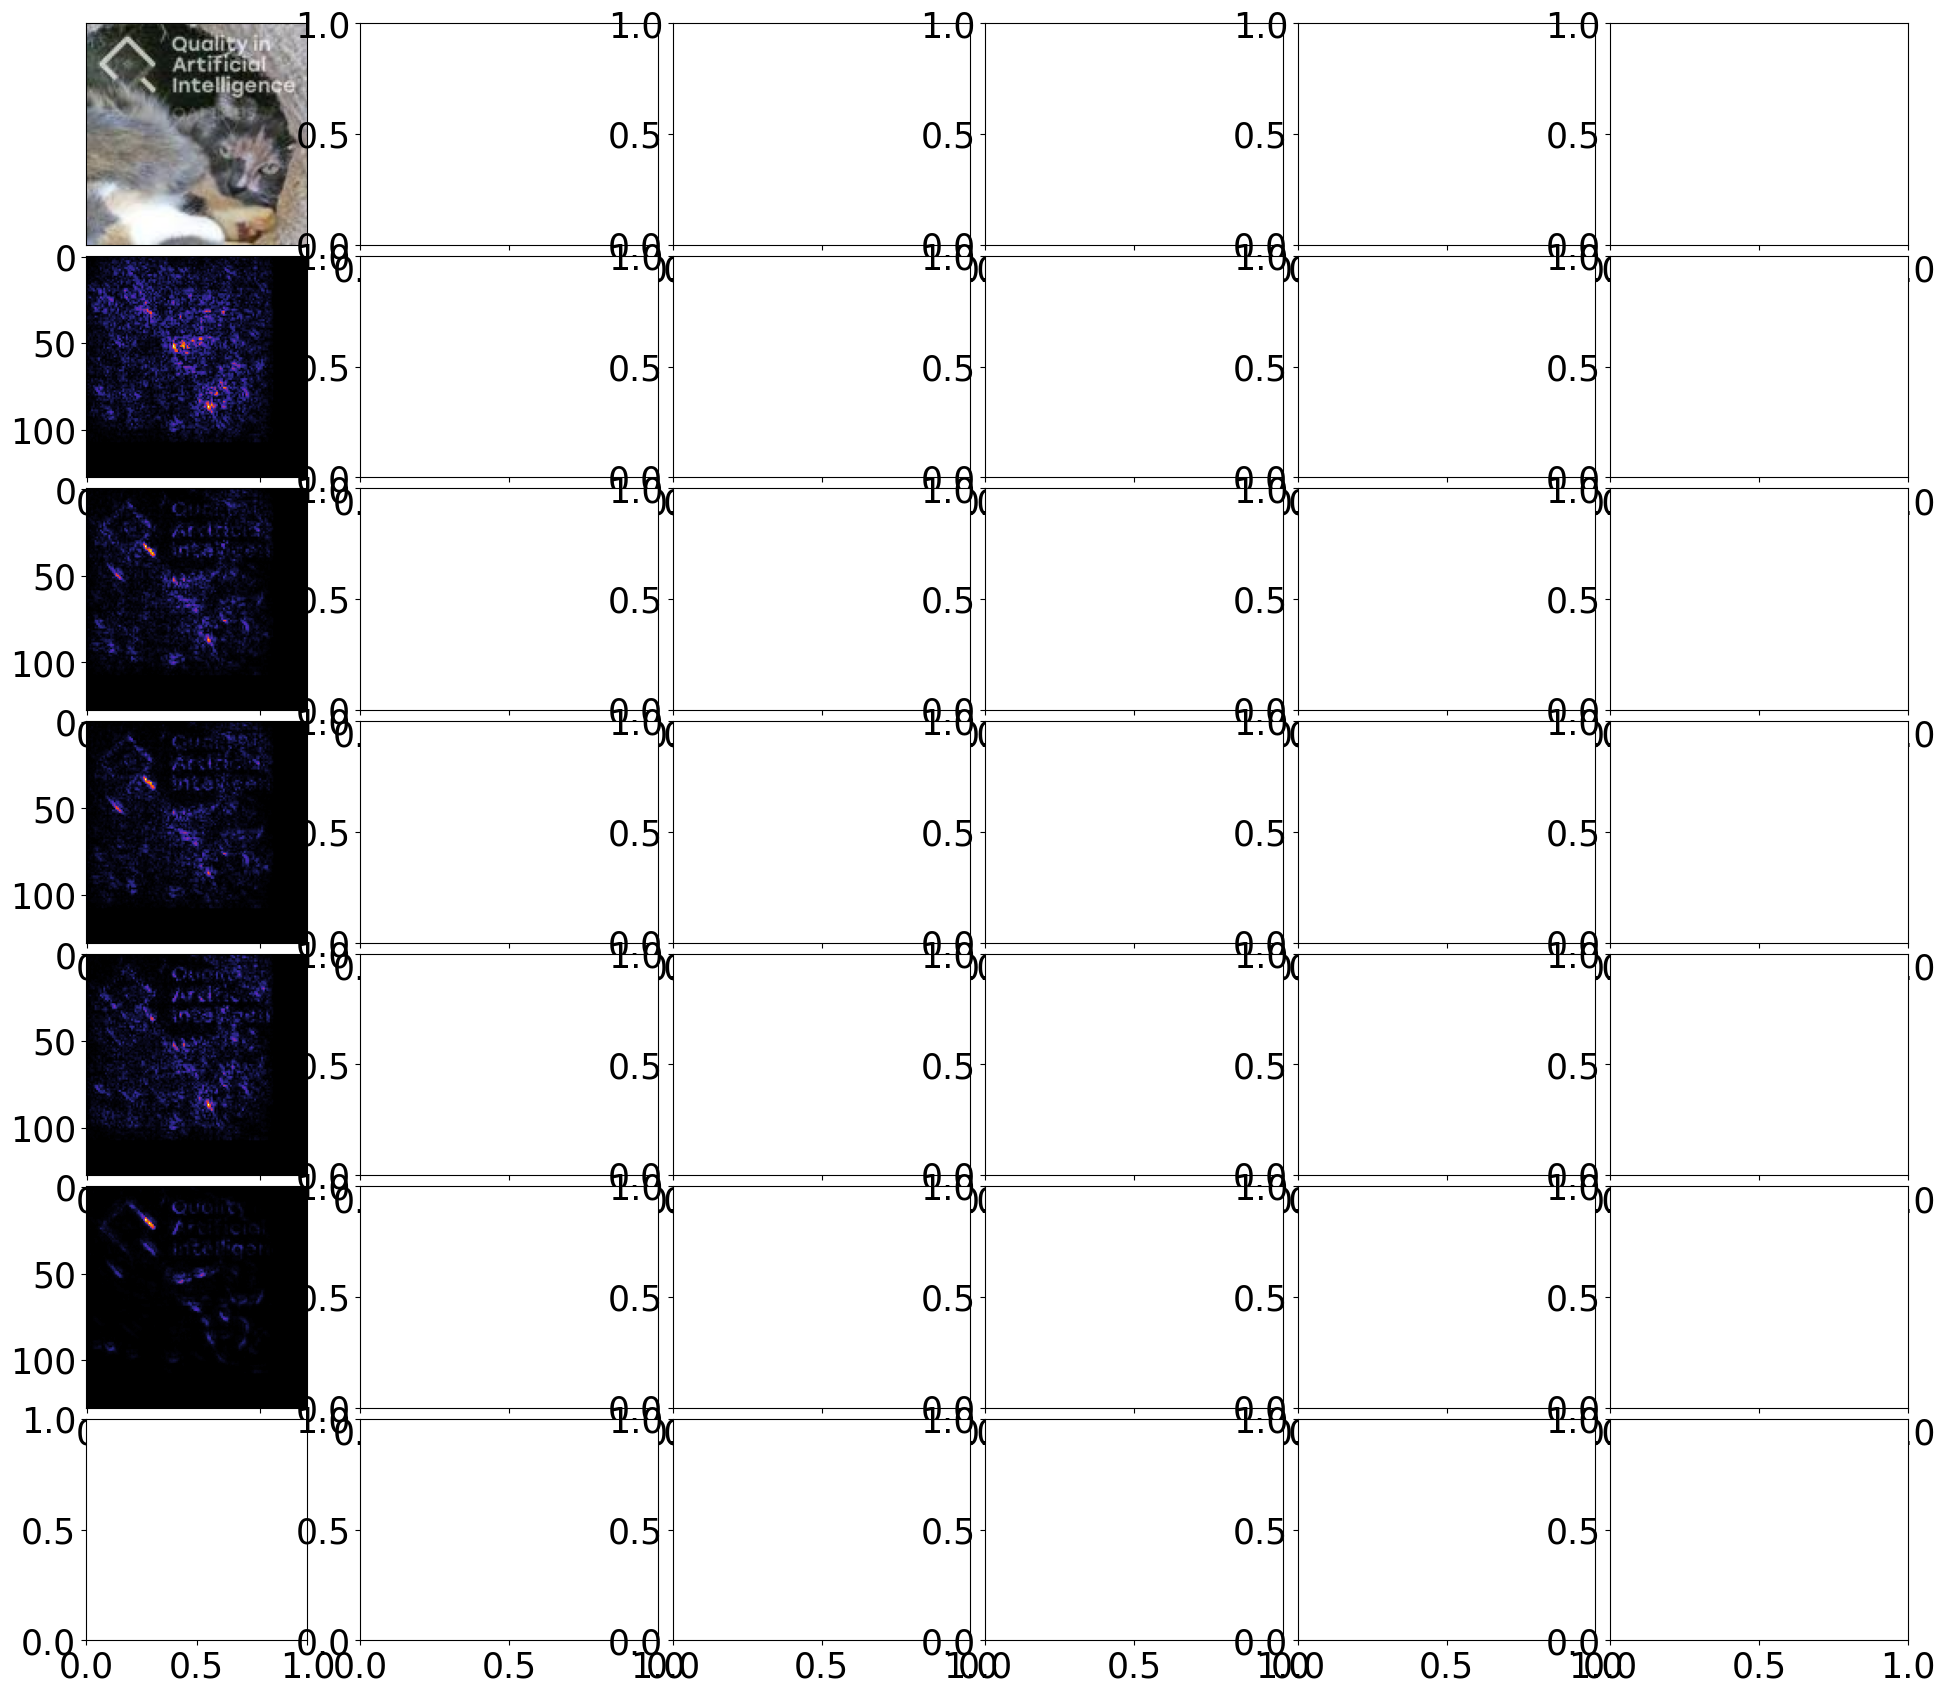

In [10]:
def plots(n,device, model_ind=0):
    #images
    watermark_image=watermark_dataset[n][0]    
    data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
    no_watermark_image=no_watermark_dataset[n][0]
    data_no_watermark=torch.tensor(no_watermark_image).unsqueeze(0).to(device,dtype=torch.float)
    
    #target (same for both images)
    target=watermark_dataset[n][1]
    
    #models
#     model_conf = model_confounder.to(device)
#     model_sup = model_supressor.to(device)
#     model_no = model_no_water.to(device)

    model_conf=load_trained(f'./cnn_conf_{model_ind}.pt').to(device)
    model_sup=load_trained(f'./cnn_sup_{model_ind}.pt').to(device)
    model_no=load_trained(f'./cnn_no_{model_ind}.pt').to(device)
    
    #plots 
    fig, axs = plt.subplots(7, 6,figsize=(24, 21))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    font_size=25
    plt.rcParams['font.size'] = font_size
    plt.rc('axes', titlesize=font_size) #title
    
    atts={'watermark_conf':plot_atts(data_watermark,model_conf,target),
          'watermark_sup':plot_atts(data_watermark,model_sup,target),
          'watermark_no':plot_atts(data_watermark,model_no,target),
          'no_watermark_conf':plot_atts(data_no_watermark,model_conf,target),
          'no_watermark_sup':plot_atts(data_no_watermark,model_sup,target),
          'no_watermark_no':plot_atts(data_no_watermark,model_no,target)}
    
    
    original_imgs=[watermark_image,no_watermark_image,
                   watermark_image,no_watermark_image,
                   watermark_image,no_watermark_image]
    
    images=[atts['watermark_conf'][0],atts['no_watermark_conf'][0],
            atts['watermark_sup'][0],atts['no_watermark_sup'][0],
            atts['watermark_no'][0],atts['no_watermark_no'][0]]
    
    probs=[atts['watermark_conf'][1],atts['no_watermark_conf'][1],
            atts['watermark_sup'][1],atts['no_watermark_sup'][1],
            atts['watermark_no'][1],atts['no_watermark_no'][1]]
    
    labels=['Original', 'Deconv','Int. Grad.','Grad SHAP',r'LRP-$\epsilon$', r'LRP-$\alpha \beta$', 'LIME']
    cmap='cubehelix'
    cmap='hot'
    cmap='inferno'
    cmap='CMRmap'
    
    for i in range(6): #images watermark/no watermark
        for j in range(7): #original image + XAI methods
            axs[j,i].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
            
            axs[0,i].imshow(original_imgs[i].transpose(1,2,0))
            axs[1,i].imshow(images[i]['deconv'],cmap=cmap)
            axs[2,i].imshow(images[i]['gradients'],cmap=cmap)
            axs[3,i].imshow(images[i]['shap'],cmap=cmap)
            axs[4,i].imshow(images[i]['lrp'],cmap=cmap)
            axs[5,i].imshow(images[i]['lrp-ab'],cmap=cmap)
            axs[6,i].imshow(images[i]['lime'],cmap=cmap)
         
#             axs[0,i].title.set_text(f'p={round(float(probs[i][target].cpu().detach().numpy()),3)}')
            
            if i==0:
                axs[j,0].set_ylabel(labels[j]) 
    
    #titles model type
    plt.figtext(0.25,0.92,"Model trained with \n Confounder dataset", va="center", ha="center", size=font_size)
    plt.figtext(0.53,0.92,"Model trained with \n Suppressor dataset", va="center", ha="center", size=font_size)
    plt.figtext(0.78,0.92,"Model trained with \n No Watermark dataset", va="center", ha="center", size=font_size)
    plt.savefig(f'qualitative_{n}.png', bbox_inches='tight')
    
torch.manual_seed(SEED)  

#dog n=1000
#cat n=2

# max diff = 628

plots(0,device,0)

# for ind in top_inds:
#     plots(ind,device,0)

# Energy

In [11]:
import os
# import nibabel as nib

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import time
import pickle
import random

from scipy import ndimage

# from skimage.filters import threshold_otsu
# from skimage.measure import label, regionprops
# from skimage import transform
# from skimage.transform import resize
# import skimage.exposure as skie

import ot

import torch
from torch import manual_seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
# from torchsummary import summary
import torchvision
from torchvision import datasets, models, transforms

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

import gc 
from PIL import Image 

torch.cuda.is_available()

torch.set_num_threads(3)



from captum.attr import IntegratedGradients, Saliency, DeepLift, DeepLiftShap, GradientShap  
from captum.attr import GuidedBackprop, Deconvolution, LRP, InputXGradient, Lime

# from zennit.composites import EpsilonPlusFlat
# from zennit.composites import EpsilonAlpha2Beta1



def rescale_values(image,max_val,min_val):
    '''
    image - numpy array
    max_val/min_val - float
    '''
    return (image-image.min())/(image.max()-image.min())*(max_val-min_val)+min_val



<IPython.core.display.Javascript object>


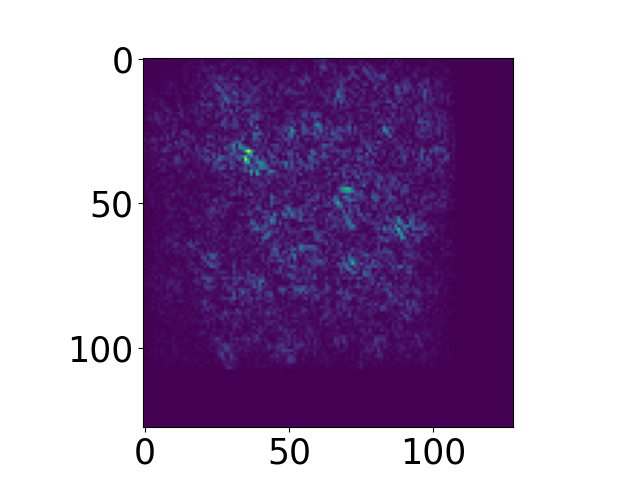

In [12]:
%matplotlib notebook
import os
folder=os.getcwd()
watermark_path=folder+'/watermark banner.jpg'
watermark = Image.open(watermark_path)
w=int(watermark_dataset[0][0].shape[1])
h=int(watermark.size[1]*w/watermark.size[0])
watermark = watermark.resize((w,h))
watermark=np.array(watermark)
rgb=rescale_values(watermark,1,0)
r, g, blue = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
gray = 1-(0.2989 * r + 0.5870 * g + 0.1140 * blue)
white=np.ones((w,w))
white[0:gray.shape[0],0:gray.shape[1]]=gray

bin_water=1.0*(white<1)
plt.imshow(bin_water)
# plt.show()

<IPython.core.display.Javascript object>


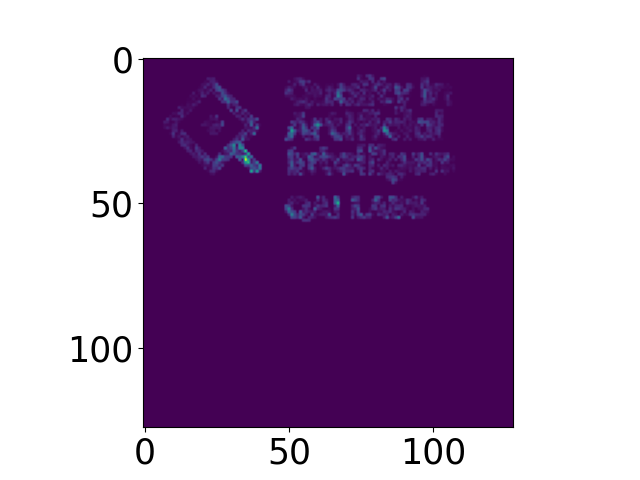

In [13]:
n=20
watermark_image=watermark_dataset[n][0] 
target=watermark_dataset[n][1] 
data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)
a,_=plot_atts(data_watermark,model_confounder,target)
plt.imshow(a['deconv'],vmax=np.max(a['deconv']),vmin=np.min(a['deconv']))

plt.figure()
plt.imshow(a['deconv']*bin_water,vmax=np.max(a['deconv']),vmin=np.min(a['deconv']))

In [14]:
def energy(att):
    image_size=att.shape[0]*att.shape[1]
    watermark_size=np.sum(bin_water)
    
    watermark_att=att*bin_water
    watermark_energy=np.sum(watermark_att)
    
    image_energy=np.sum(att)

    
    # Gives energy(watermark) = 7.858
    energy=(watermark_energy/watermark_size)/(image_energy/image_size)
    
    # Gives energy(watermark) = 1.0
#     energy = (np.sum(att*bin_water)/att.shape[0]*att.shape[1]) / (np.sum(att)/att.shape[0]*att.shape[1])
    
    return energy

In [15]:
energy(bin_water)

7.858033573141487

In [39]:
reshaped_watermark = bin_water.reshape((128*128))

watermark_inds = np.where(reshaped_watermark==1)[0]
# print(watermark_inds)
num_ones = len(watermark_inds)
half_inds = watermark_inds[:int(num_ones/2)]

copy_mark = reshaped_watermark.copy()
copy_mark[half_inds] = 0

print(energy(copy_mark.reshape((128,128))))

7.858033573141487


<IPython.core.display.Javascript object>


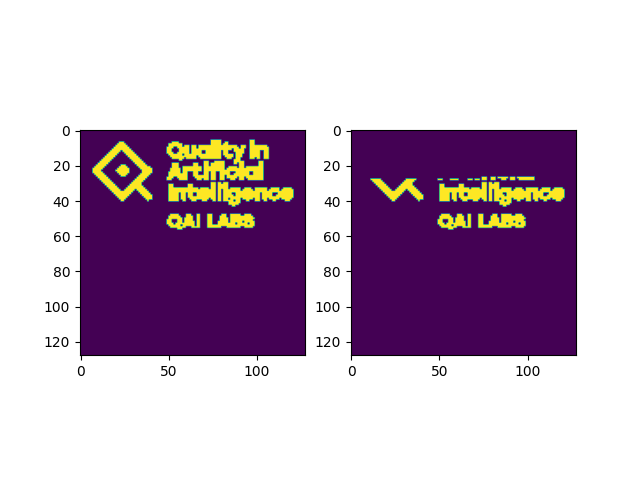

In [40]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(bin_water)
axs[1].imshow(copy_mark.reshape((128,128)))
plt.show()

In [12]:
bin_water*bin_water

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
np.sum(bin_water)

2085.0

In [14]:
np.sum(bin_water*bin_water)

2085.0

In [15]:
bin_water.shape[0]*bin_water.shape[1]

16384

<IPython.core.display.Javascript object>


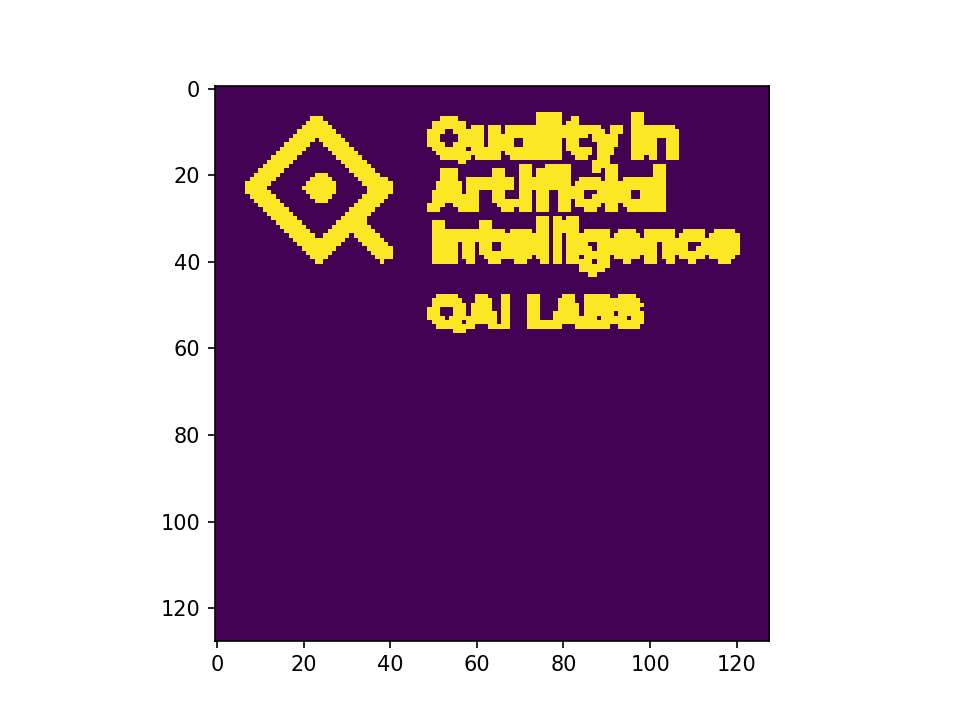

In [16]:
plt.figure()
plt.imshow(bin_water*bin_water,vmax=np.max(a['deconv']),vmin=np.min(a['deconv']))

In [17]:
print('watermark size:', np.sum(bin_water))
print('image size:', bin_water.shape[0]*bin_water.shape[1])

print('watermark_energy', np.sum(bin_water*bin_water))

watermark size: 2085.0
image size: 16384
watermark_energy 2085.0


In [20]:
energy(bin_water)

1.0

In [21]:
energy_water_conf={'deconv':[],'gradients':[],'shap':[],'lrp':[]}
energy_water_sup={'deconv':[],'gradients':[],'shap':[],'lrp':[]}
energy_water_no={'deconv':[],'gradients':[],'shap':[],'lrp':[]}

energy_no_water_conf={'deconv':[],'gradients':[],'shap':[],'lrp':[]}
energy_no_water_sup={'deconv':[],'gradients':[],'shap':[],'lrp':[]}
energy_no_water_no={'deconv':[],'gradients':[],'shap':[],'lrp':[]}

model_conf=load_trained('./artifacts/cnn_conf.pt').to(device)
model_sup=load_trained('./artifacts/cnn_sup.pt').to(device)
model_no=load_trained('./artifacts/cnn_no.pt').to(device)

folder=os.getcwd()+'/images'
print(folder)
t0=time.time()

n_test = 50

# for i,w_image in enumerate(watermark_dataset[:n_test]):
    
for i in range(n_test):
    w_image = watermark_dataset[n_test]
    image=w_image[0]
    target=w_image[1]
    
    example=torch.tensor(image).unsqueeze(0).to(device,dtype=torch.float)
    
    target_conf = torch.max(model_conf(example), 1)[1].to(int)
    target_sup = torch.max(model_sup(example), 1)[1].to(int)
    target_no = torch.max(model_no(example), 1)[1].to(int)
    
#     a_conf_w,_=plot_atts(example,model_conf,target)
#     a_sup_w,_=plot_atts(example,model_sup,target)
#     a_no_w,_=plot_atts(example,model_no,target)
    
    a_conf_w,_=plot_atts(example,model_conf,target_conf)
    a_sup_w,_=plot_atts(example,model_sup,target_sup)
    a_no_w,_=plot_atts(example,model_no,target_no)
    
    for method in list(energy_water_conf.keys()):
        energy_water_conf[method].append(energy(a_conf_w[method]))
        energy_water_sup[method].append(energy(a_sup_w[method]))
        energy_water_no[method].append(energy(a_no_w[method]))

#     if i%10==0:
#         print(f'{i} out of {len(watermark_dataset)}')
#         print(time.time()-t0)
#         t0=time.time()
                
# for i,w_image in enumerate(no_watermark_dataset[:n_test]):
    w_image = no_watermark_dataset[n_test]
    image=w_image[0]
    target=w_image[1]
    
    example=torch.tensor(image).unsqueeze(0).to(device,dtype=torch.float)
    
    target_conf = torch.max(model_conf(example), 1)[1].to(int)
    target_sup = torch.max(model_sup(example), 1)[1].to(int)
    target_no = torch.max(model_no(example), 1)[1].to(int)
    
#     a_conf_nw,_=plot_atts(example,model_confounder,target)
#     a_sup_nw,_=plot_atts(example,model_supressor,target)
#     a_no_nw,_=plot_atts(example,model_no_water,target)

    a_conf_nw,_=plot_atts(example,model_confounder,target_conf)
    a_sup_nw,_=plot_atts(example,model_supressor,target_sup)
    a_no_nw,_=plot_atts(example,model_no_water,target_no)
    
    for method in list(energy_water_conf.keys()):
        energy_no_water_conf[method].append(energy(a_conf_nw[method]))
        energy_no_water_sup[method].append(energy(a_sup_nw[method]))
        energy_no_water_no[method].append(energy(a_no_nw[method]))
    
    if i%10==0:
        print(f'{i} out of {len(no_watermark_dataset)}')
        print(time.time()-t0)
        t0=time.time()


C:\Users\clark01\Documents\braindata\debugging_xai/images
0 out of 3000
5.94344687461853
10 out of 3000
62.61128234863281
20 out of 3000
68.16038513183594
30 out of 3000
119.8517050743103
40 out of 3000
70.18591475486755


In [ ]:
# 0 out of 3000
# 6.566878318786621
# 10 out of 3000
# 65.88069796562195
# 20 out of 3000
# 62.44131374359131
# 30 out of 3000
# 61.75708293914795
# 40 out of 3000
# 64.37344002723694
# 0 out of 3000
# 6.211118698120117
# 10 out of 3000
# 54.20735311508179
# 20 out of 3000
# 30.906477689743042
# 30 out of 3000
# 33.297953844070435
# 40 out of 3000
# 33.80549597740173

In [23]:
train_energy = []
for method in ['deconv', 'gradients', 'shap', 'lrp']:
#     comb_water_conf = []
#     comb_water_sup = []
#     comb_water_no = []
    
#     comb_no_water_conf = []
#     comb_no_water_sup = []
#     comb_no_water_no = []
    
        
#     comb_water_conf = energy_water_conf[method])
#     comb_water_sup.append(energy_water_sup[method])
#     comb_water_no.append(energy_water_no[method])

#     comb_no_water_conf.append(energy_no_water_conf[method])
#     comb_no_water_sup.append(energy_no_water_sup[method])
#     comb_no_water_no.append(energy_no_water_no[method])
        
        
        
        
    train_energy.append([[energy_no_water_conf[method], energy_water_conf[method]],
                [energy_no_water_sup[method], energy_water_sup[method]],
                [energy_no_water_no[method], energy_water_no[method]]])

In [24]:
train_energy[0][0][1]

[0.3002160675777297,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179

In [25]:
train_energy[j][i][1]

[0.3002160675777297,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179408334713,
 0.30020179

<IPython.core.display.Javascript object>


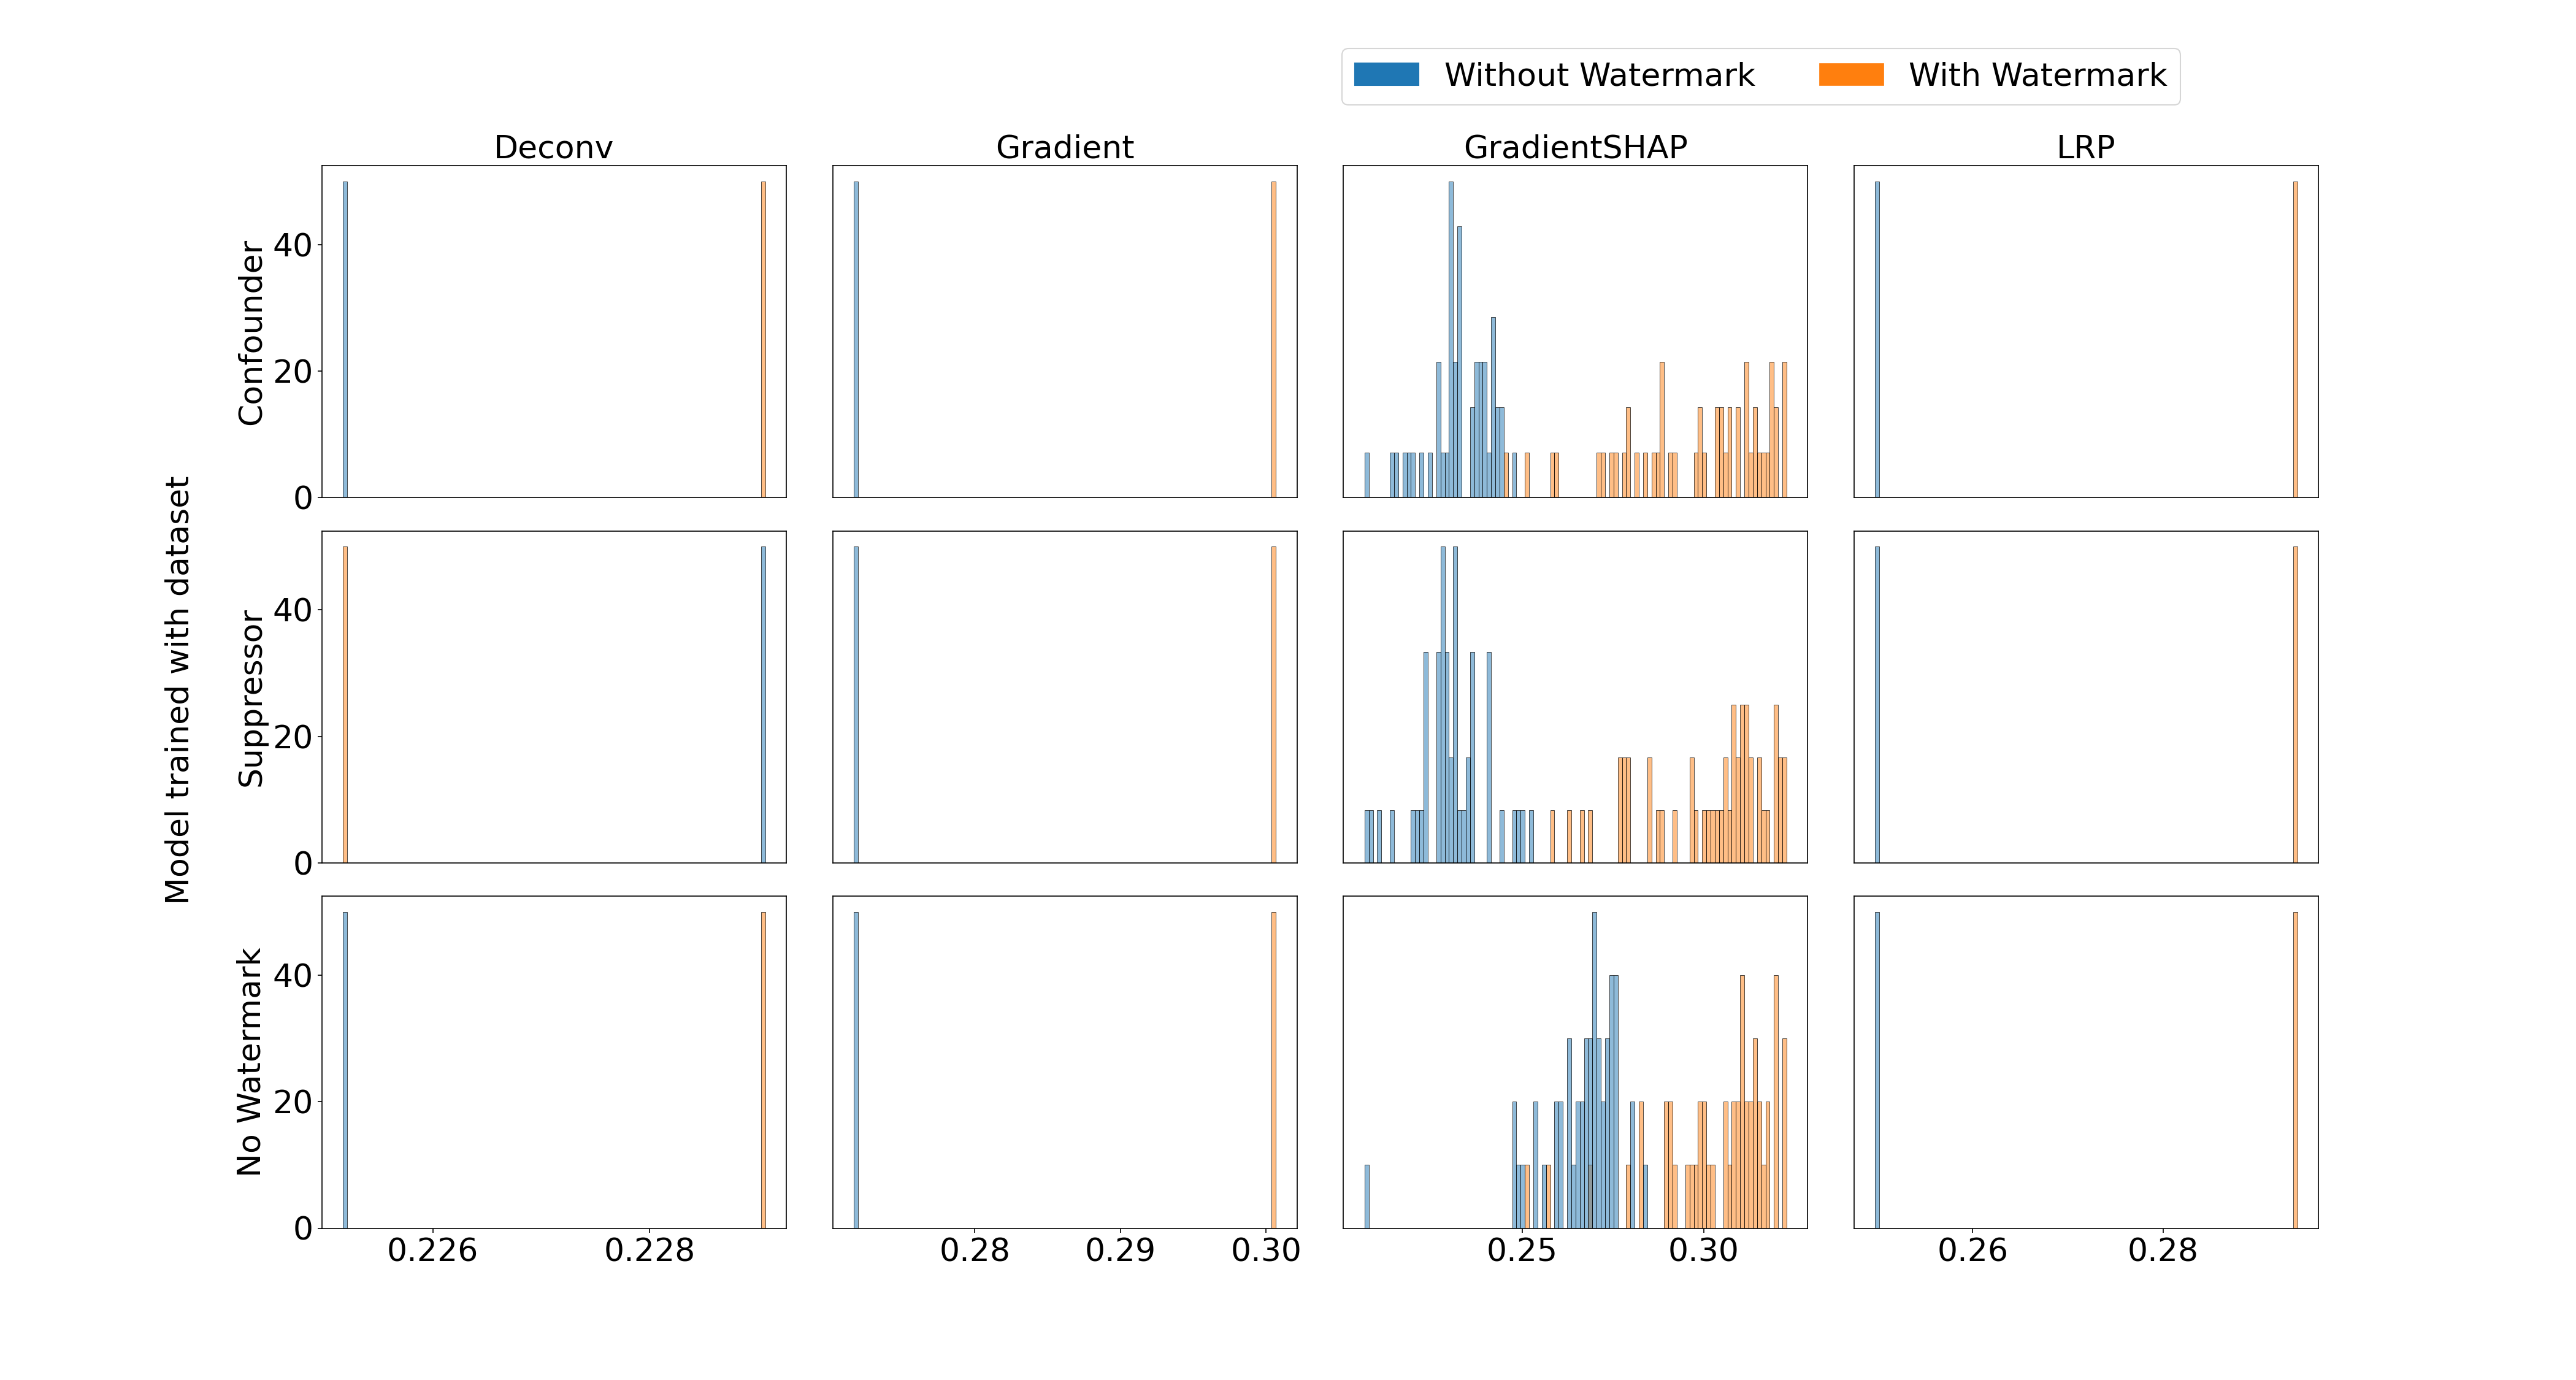

Text(0, 0.5, 'No Watermark')

In [26]:
import seaborn as sns
fig, axs = plt.subplots(3, 4,figsize=(28, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
font_size=25
plt.rcParams['font.size'] = font_size
plt.rc('axes', titlesize=font_size) #title


# train_energy = [[energy_no_water_conf, energy_water_conf],
#                 [energy_no_water_sup, energy_water_sup],
#                 [energy_no_water_no, energy_water_no]]

for i in range(3): #model
    for j in range(4): #method
        #ex: train_energy[method][train][variant]
        g=sns.histplot(ax=axs[i, j],data=[train_energy[j][i][0],train_energy[j][i][1]],bins=100)
        axs[i, j].legend([],[], frameon=False)
        axs[i,j].set_ylabel('')
#         axs[i,j].set_ylim(0,200)
        
        if i!=2:
            axs[i,j].set_xticks([])
            
        if j!=0:
            axs[i,j].set_yticks([])
        
#     axs[i,0].set_xlim(0, 5)
#     axs[i,1].set_xlim(0, 5)
#     axs[i,2].set_xlim(0, 5)
#     axs[i,3].set_xlim(0, 5)
    
axs[0,0].legend(['Without Watermark', 'With Watermark'],loc='upper center', bbox_to_anchor=(3.1, 1.4), ncol=2)
leg = axs[0,0].get_legend()
leg.legendHandles[0].set_color(sns.color_palette()[0])
leg.legendHandles[1].set_color(sns.color_palette()[1])
axs[0,0].title.set_text('Deconv')
axs[0,1].title.set_text('Gradient')
axs[0,2].title.set_text('GradientSHAP')
axs[0,3].title.set_text(r'LRP')
# axs[0,4].title.set_text(r'LRP-$\epsilon$')
# axs[0,3].title.set_text('LIME')
# axs[0,5].title.set_text(r'LRP-$\alpha$$\beta$')

plt.figtext(0.07,0.5,"Model trained with dataset", va="center", ha="center", size=font_size,rotation='vertical')
axs[0,0].set_ylabel('Confounder')
axs[1,0].set_ylabel('Suppressor')
axs[2,0].set_ylabel('No Watermark')


In [ ]:
with open('energy_water_conf.pickle', 'wb') as f:
    pickle.dump(energy_water_conf, f) 

In [ ]:
# import pickle
    
# with open('energy_water_conf.pickle', 'wb') as f:
#     pickle.dump(energy_water_conf, f)    
# with open('energy_water_sup.pickle', 'wb') as f:
#     pickle.dump(energy_water_sup, f)    
# with open('energy_water_no.pickle', 'wb') as f:
#     pickle.dump(energy_water_no, f)    
    
# with open('energy_no_water_conf.pickle', 'wb') as f:
#     pickle.dump(energy_no_water_conf, f)    
# with open('energy_no_water_sup.pickle', 'wb') as f:
#     pickle.dump(energy_no_water_sup, f)    
# with open('energy_no_water_no.pickle', 'wb') as f:
#     pickle.dump(energy_no_water_no, f)



In [16]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
model_ind = 0
file = open(f'energy_water_conf_{model_ind}.pickle', 'rb')
energy_water_conf = pickle.load(file)

file = open(f'energy_water_sup_{model_ind}.pickle', 'rb')
energy_water_sup = pickle.load(file)

file = open(f'energy_water_no_{model_ind}.pickle', 'rb')
energy_water_no = pickle.load(file)

file = open(f'energy_no_water_conf_{model_ind}.pickle', 'rb')
energy_no_water_conf = pickle.load(file)

file = open(f'energy_no_water_sup_{model_ind}.pickle', 'rb')
energy_no_water_sup = pickle.load(file)

file = open(f'energy_no_water_no_{model_ind}.pickle', 'rb')
energy_no_water_no = pickle.load(file)

In [ ]:
energy_water_conf['lrp']

In [ ]:
energy_no_water_conf['lrp']

In [ ]:
energy_water_conf.keys()

In [ ]:
l3 = [l1-l2 for l1, l2 in zip(energy_water_no['lrp'], energy_no_water_no['lrp'])]
l3_sorted = l3.copy()
l3_sorted.sort(reverse=True)

In [ ]:
l3_sorted[:10]

In [ ]:
top_inds = []
for ind in l3_sorted[:10]:
    top_inds.append(l3.index(ind))

In [ ]:
top_inds

In [ ]:
l3.index(l3_sorted[1000])

In [ ]:
l3_sorted[1000]

In [ ]:
len(l3)

In [ ]:
lst = []
print(len(energy_water_conf['deconv']))
for i in range(5):
    lst.extend(energy_water_conf['deconv'])
print(len(lst))

In [31]:
train_energy=[]
methods = ['deconv', 'int_grads', 'shap', 'lrp'] # lime just nan values
# methods = ['deconv', 'int_grads', 'shap', 'lrp']
n_test = 3000

for method in methods:
    comb_water_conf = []
    comb_water_sup = []
    comb_water_no = []
    
    comb_no_water_conf = []
    comb_no_water_sup = []
    comb_no_water_no = []
    
    for model_ind in range(5):
        file = open(f'energy_water_conf_pred_{model_ind}.pickle', 'rb')
        energy_water_conf = pickle.load(file)

        file = open(f'energy_water_sup_pred_{model_ind}.pickle', 'rb')
        energy_water_sup = pickle.load(file)

        file = open(f'energy_water_no_pred_{model_ind}.pickle', 'rb')
        energy_water_no = pickle.load(file)

        file = open(f'energy_no_water_conf_pred_{model_ind}.pickle', 'rb')
        energy_no_water_conf = pickle.load(file)

        file = open(f'energy_no_water_sup_pred_{model_ind}.pickle', 'rb')
        energy_no_water_sup = pickle.load(file)

        file = open(f'energy_no_water_no_pred_{model_ind}.pickle', 'rb')
        energy_no_water_no = pickle.load(file)
        
        comb_water_conf.extend(energy_water_conf[method][:n_test])
        comb_water_sup.extend(energy_water_sup[method][:n_test])
        comb_water_no.extend(energy_water_no[method][:n_test])

        comb_no_water_conf.extend(energy_no_water_conf[method][:n_test])
        comb_no_water_sup.extend(energy_no_water_sup[method][:n_test])
        comb_no_water_no.extend(energy_no_water_no[method][:n_test])
        
        
        
        
    train_energy.append([[comb_no_water_conf, comb_water_conf],
                [comb_no_water_sup, comb_water_sup],
                [comb_no_water_no, comb_water_no]])

#     train_energy.append([[comb_water_conf, comb_no_water_conf],
#                 [comb_water_sup, comb_no_water_sup],
#                 [comb_water_no, comb_no_water_no]])
    
np.array(train_energy).shape

(4, 3, 2, 15000)

In [25]:
train_energy

[[[[0.21698041765145426,
    0.2648169648716748,
    0.22708219088177828,
    0.22141214973807935,
    0.19333998557645293,
    0.2108500117436311,
    0.22189383625453812,
    0.17554412825048268,
    0.2543014992325373,
    0.16945436067609318,
    0.20419196750065607,
    0.21035493173036549,
    0.24622835340951052,
    0.17617032363741658,
    0.13632460545244052,
    0.2771308844927939,
    0.2075965374020714,
    0.2817814505257507,
    0.22119374521526042,
    0.23635589032631818,
    0.25298779668858346,
    0.2938004373799808,
    0.22468221657899623,
    0.2729545843421112,
    0.19706026620654263,
    0.18014595642883513,
    0.2290999537051791,
    0.21173974939845377,
    0.2261263372782653,
    0.20433664271527846,
    0.19275550993753568,
    0.2297904072943761,
    0.20352361465634095,
    0.2341669811192063,
    0.22502704820902328,
    0.23374604807125773,
    0.15282550927669458,
    0.1657780525707195,
    0.20714957137496928,
    0.236247335593448,
    0.249786546

In [27]:
file = open(f'zennit_energy_water_conf_pred_0.pickle', 'rb')
zennit_energy_water_conf = pickle.load(file)


In [29]:
zennit_energy_water_conf.keys()

dict_keys(['lrp'])

In [32]:
train_energy_zennit=[]
# methods = ['lrp_ab'] # lime just nan values
# methods = ['deconv', 'int_grads', 'shap', 'lrp']
n_test = 3000

for method in ['lrp']:
#     comb_water_conf = []
#     comb_water_sup = []
#     comb_water_no = []
    
#     comb_no_water_conf = []
#     comb_no_water_sup = []
#     comb_no_water_no = []
    
    for model_ind in range(5):
        file = open(f'zennit_energy_water_conf_pred_{model_ind}.pickle', 'rb')
        zennit_energy_water_conf = pickle.load(file)

        file = open(f'zennit_energy_water_sup_pred_{model_ind}.pickle', 'rb')
        zennit_energy_water_sup = pickle.load(file)

        file = open(f'zennit_energy_water_no_pred_{model_ind}.pickle', 'rb')
        zennit_energy_water_no = pickle.load(file)

        file = open(f'zennit_energy_no_water_conf_pred_{model_ind}.pickle', 'rb')
        zennit_energy_no_water_conf = pickle.load(file)

        file = open(f'zennit_energy_no_water_sup_pred_{model_ind}.pickle', 'rb')
        zennit_energy_no_water_sup = pickle.load(file)

        file = open(f'zennit_energy_no_water_no_pred_{model_ind}.pickle', 'rb')
        zennit_energy_no_water_no = pickle.load(file)
        
        comb_water_conf.extend(zennit_energy_water_conf[method][:n_test])
        comb_water_sup.extend(zennit_energy_water_sup[method][:n_test])
        comb_water_no.extend(zennit_energy_water_no[method][:n_test])

        comb_no_water_conf.extend(zennit_energy_no_water_conf[method][:n_test])
        comb_no_water_sup.extend(zennit_energy_no_water_sup[method][:n_test])
        comb_no_water_no.extend(zennit_energy_no_water_no[method][:n_test])
        
        
        
        
    train_energy_zennit.append([[comb_no_water_conf, comb_water_conf],
                [comb_no_water_sup, comb_water_sup],
                [comb_no_water_no, comb_water_no]])

#     train_energy.append([[comb_water_conf, comb_no_water_conf],
#                 [comb_water_sup, comb_no_water_sup],
#                 [comb_water_no, comb_no_water_no]])
    
np.array(train_energy_zennit).shape

(1, 3, 2, 30000)

In [ ]:
train= 2 # 0 conf 1 sup 2 no
method= 2 #0 deconv, 1 gradients, 2 shap, 3 lrp
variant= 1 #0 water, 1 no water


len(train_energy[method][train][variant])

In [33]:
for n_method in range(5):
#     print(list(energy_no_water_conf.keys())[n_method])
    print(methods[n_method])
    print('====== dataset:watermark ======')
    
    print('model: confounder ', round(np.mean(np.array(train_energy[n_method][0][1])),3))
    print('model: supressor', round(np.mean(np.array(train_energy[n_method][1][1])),3))
    print('model: no watermark  ', round(np.mean(np.array(train_energy[n_method][2][1])),3))
    
    print('====== dataset:no watermark ======')
    
    print('model: confounder', round(np.mean(np.array(train_energy[n_method][0][0])),3))
    print('model: supressor ', round(np.mean(np.array(train_energy[n_method][1][0])),3))
    print('model: no watermark ', round(np.mean(np.array(train_energy[n_method][2][0])),3))
    print()

deconv
====== dataset:watermark ======
model: confounder  0.233
model: supressor 0.21
model: no watermark   0.265
====== dataset:no watermark ======
model: confounder 0.211
model: supressor  0.201
model: no watermark  0.216

int_grads
====== dataset:watermark ======
model: confounder  0.295
model: supressor 0.276
model: no watermark   0.358
====== dataset:no watermark ======
model: confounder 0.201
model: supressor  0.193
model: no watermark  0.217

shap
====== dataset:watermark ======
model: confounder  0.297
model: supressor 0.275
model: no watermark   0.351
====== dataset:no watermark ======
model: confounder 0.202
model: supressor  0.192
model: no watermark  0.216

lrp
====== dataset:watermark ======
model: confounder  0.345
model: supressor 0.307
model: no watermark   0.352
====== dataset:no watermark ======
model: confounder 0.204
model: supressor  0.202
model: no watermark  0.211



IndexError: list index out of range

In [ ]:
# for n_method in range(5):
#     print(list(energy_no_water_conf.keys())[n_method])
print('LRP alpha-beta from zennit')
print('====== dataset:watermark ======')

print('model: confounder ', round(np.mean(np.array(train_energy_zennit[0][0][1])),3))
print('model: supressor', round(np.mean(np.array(train_energy_zennit[0][1][1])),3))
print('model: no watermark  ', round(np.mean(np.array(train_energy_zennit[0][2][1])),3))

print('====== dataset:no watermark ======')

print('model: confounder', round(np.mean(np.array(train_energy_zennit[0][0][0])),3))
print('model: supressor ', round(np.mean(np.array(train_energy_zennit[0][1][0])),3))
print('model: no watermark ', round(np.mean(np.array(train_energy_zennit[0][2][0])),3))
print()

In [35]:
train_energy.append(train_energy_zennit[0])

<IPython.core.display.Javascript object>


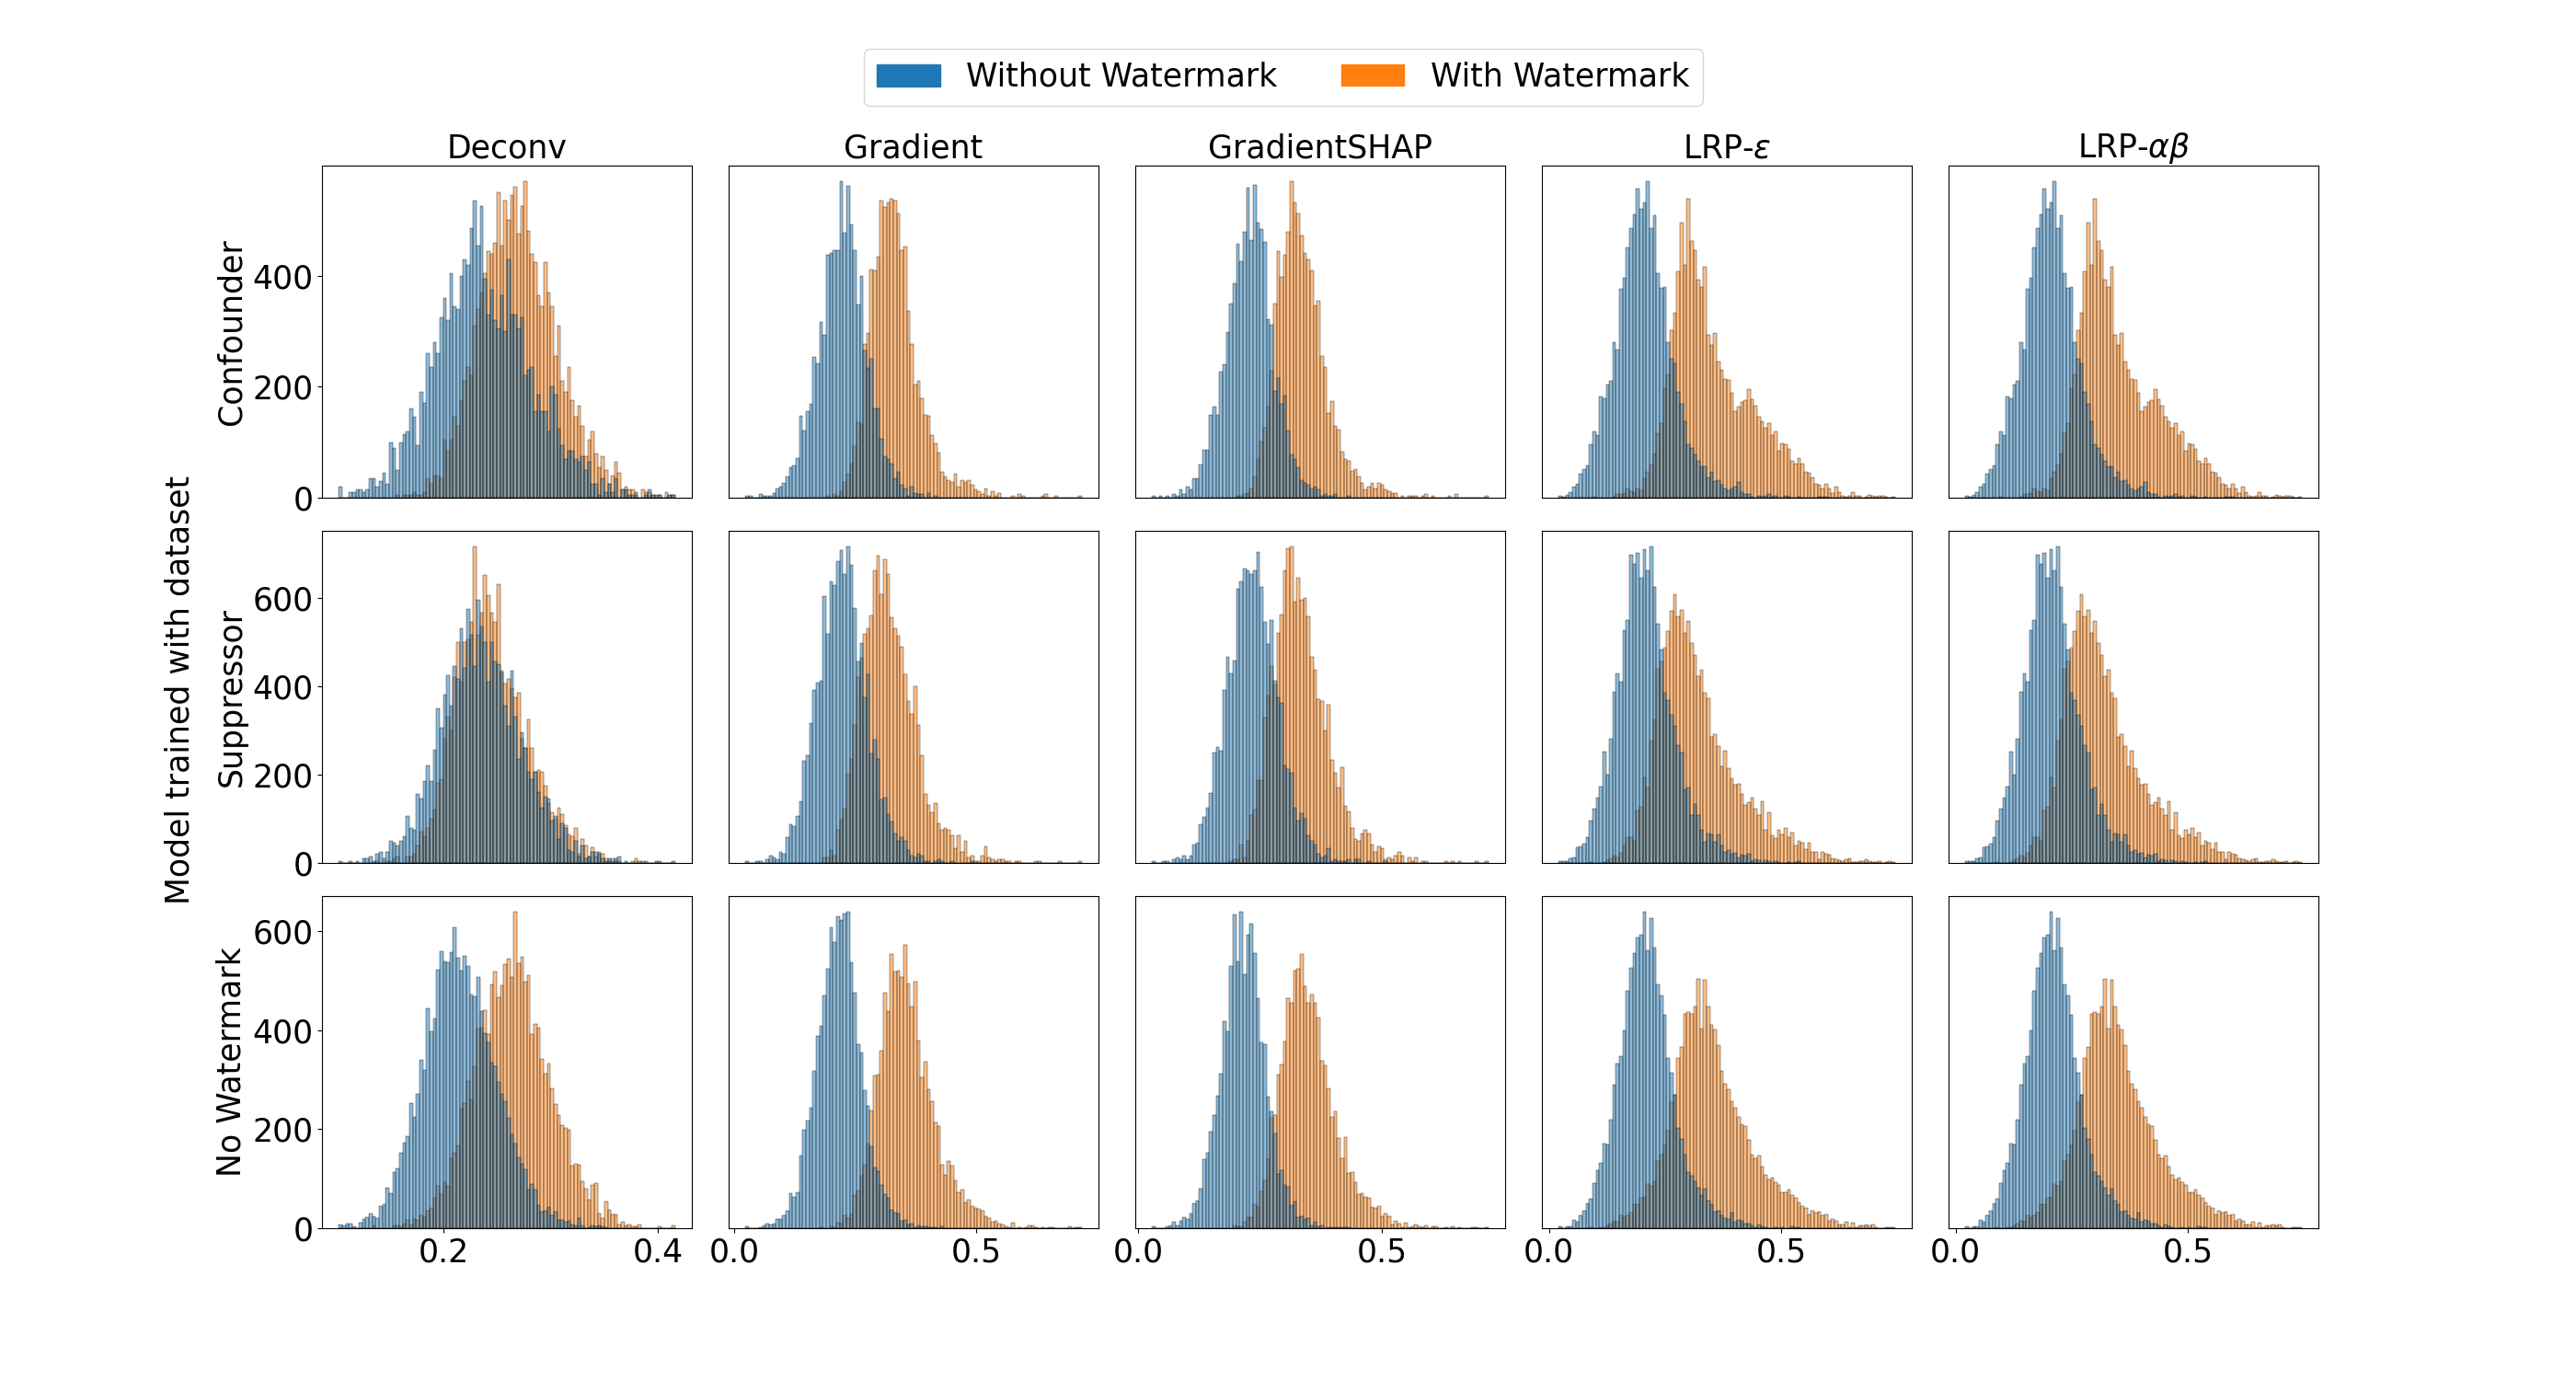

Text(0, 0.5, 'No Watermark')

In [39]:


import seaborn as sns
fig, axs = plt.subplots(3, 5,figsize=(28, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
font_size=25
plt.rcParams['font.size'] = font_size
plt.rc('axes', titlesize=font_size) #title

for i in range(3): #model
    for j in range(5): #method
        #ex: train_energy[method][train][variant]
        g=sns.histplot(ax=axs[i, j],data=[train_energy[j][i][0],train_energy[j][i][1]],bins=100)
        axs[i, j].legend([],[], frameon=False)
        axs[i,j].set_ylabel('')
#         axs[i,j].set_xlim(0,0.6)
        
        if i!=2:
            axs[i,j].set_xticks([])
            
        if j!=0:
            axs[i,j].set_yticks([])
        
#     axs[i,0].set_xlim(0, 5)
#     axs[i,1].set_xlim(0, 5)
#     axs[i,2].set_xlim(0, 5)
#     axs[i,3].set_xlim(0, 5)
    
axs[0,0].legend(['Without Watermark', 'With Watermark'],loc='upper center', bbox_to_anchor=(2.6, 1.4), ncol=2)
leg = axs[0,0].get_legend()
leg.legendHandles[0].set_color(sns.color_palette()[0])
leg.legendHandles[1].set_color(sns.color_palette()[1])
axs[0,0].title.set_text('Deconv')
axs[0,1].title.set_text('Gradient')
axs[0,2].title.set_text('GradientSHAP')
axs[0,3].title.set_text(r'LRP-$\epsilon$')
# axs[0,3].title.set_text('LIME')
axs[0,4].title.set_text(r'LRP-$\alpha$$\beta$')

plt.figtext(0.07,0.5,"Model trained with dataset", va="center", ha="center", size=font_size,rotation='vertical')
axs[0,0].set_ylabel('Confounder')
axs[1,0].set_ylabel('Suppressor')
axs[2,0].set_ylabel('No Watermark')


## What's going on with LRP?

In [ ]:
energy_water_conf={'lrp':[]}
energy_water_sup={'lrp':[]}
energy_water_no={'lrp':[]}

model_conf=load_trained('./cnn_conf_0.pt').to(device)
model_sup=load_trained('./cnn_sup_0.pt').to(device)
model_no=load_trained('./cnn_no_0.pt').to(device)
rgb_weights = [0.2989, 0.5870, 0.1140]
n_test = 1000

folder=os.getcwd()+'/images'
print(folder)
t0=time.time()
for i,w_image in enumerate(watermark_dataset[:n_test]):
    image=w_image[0]
    target=w_image[1]
    
    example=torch.tensor(image).unsqueeze(0).to(device,dtype=torch.float)
    
#     a_conf_w,_=plot_atts(example,model_conf,target)
# #     print(a_conf_w)
#     a_sup_w,_=plot_atts(example,model_sup,target)
#     a_no_w,_=plot_atts(example,model_no,target)
    
    
#     lime_att_conf=np.transpose(Lime(model_conf).attribute(example,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
#     grayscale_att_lime_conf = np.dot(lime_att_conf[...,:3], rgb_weights)
    
#     lime_att_sup=np.transpose(Lime(model_sup).attribute(example,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
#     grayscale_att_lime_sup = np.dot(lime_att_sup[...,:3], rgb_weights)
    
#     lime_att_no=np.transpose(Lime(model_no).attribute(example,target=target).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
#     grayscale_att_lime_no = np.dot(lime_att_no[...,:3], rgb_weights)

    lrp_att_conf = lrp(torch.tensor(example),model_conf,device)
    lrp_att_sup = lrp(torch.tensor(example),model_sup,device)
    lrp_att_no = lrp(torch.tensor(example),model_no,device)
    
    for method in list(energy_water_conf.keys()):
        energy_water_conf[method].append(energy(abs(lrp_att_conf)))
        energy_water_sup[method].append(energy(abs(lrp_att_sup)))
        energy_water_no[method].append(energy(abs(lrp_att_no)))

    if i%100==0:
        print(f'{i} out of {len(watermark_dataset)}')
        print(time.time()-t0)
        t0=time.time()
                
# energy_no_water_conf={'lime':[]}
# energy_no_water_sup={'lime':[]}
# energy_no_water_no={'lime':[]}

# t0=time.time()
# for i,w_image in enumerate(no_watermark_dataset[:n_test]):
#     image=w_image[0]
#     target=w_image[1]
    
#     example=torch.tensor(image).unsqueeze(0).to(device,dtype=torch.float)
    
#     a_conf_nw,_=plot_atts(example,model_confounder,target)
#     a_sup_nw,_=plot_atts(example,model_supressor,target)
#     a_no_nw,_=plot_atts(watermark_example,model_no_water,target)
    
#     for method in list(energy_water_conf.keys()):
#         energy_no_water_conf[method].append(energy(a_conf_nw[method]))
#         energy_no_water_sup[method].append(energy(a_sup_nw[method]))
#         energy_no_water_no[method].append(energy(a_no_nw[method]))
    
#     if i%100==0:
#         print(f'{i} out of {len(no_watermark_dataset)}')
#         print(time.time()-t0)
#         t0=time.time()


In [ ]:
# def lrp(data,model,device):
#     # create a composite instance
#     #composite = EpsilonPlusFlat()
#     composite = EpsilonAlpha2Beta1()

#     # use the following instead to ignore bias for the relevance
#     # composite = EpsilonPlusFlat(zero_params='bias')

#     # make sure the input requires a gradient
#     data.requires_grad = True

#     # compute the output and gradient within the composite's context
#     with composite.context(model) as modified_model:
#         modified_model=modified_model.to(device)
#         output = modified_model(data.to(device))
#         # gradient/ relevance wrt. class/output 0
#         output.backward(gradient=torch.eye(2)[[0]].to(device))
#         # relevance is not accumulated in .grad if using torch.autograd.grad
#         # relevance, = torch.autograd.grad(output, input, torch.eye(10)[[0])

#     # gradient is accumulated in input.grad
#     att=abs(data.grad.detach().cpu().squeeze().numpy().transpose(1,2,0))

#     rgb_weights = [0.2989, 0.5870, 0.1140]
#     grayscale_att_lrp = np.dot(att[...,:3], rgb_weights)

    
#     return grayscale_att_lrp
    



n=2
test_img = no_watermark_dataset[n][0]
print(test_img.shape)
target=no_watermark_dataset[n][1]
# test_img = supressor_test[n][0]
# target=supressor_test[n][1]
transformed_img=torch.tensor(test_img)
input_image = transformed_img.unsqueeze(0)
print(input_image.shape)
data=input_image.to(device,dtype=torch.float)

plt.imshow(input_image.squeeze().to('cpu').numpy().transpose(1,2,0))
plt.figure()
grayscale_att_lrp=lrp(data,model_supressor,device)
plt.imshow(abs(grayscale_att_lrp))
    
    

In [ ]:
lime_att_sup=np.transpose(Lime(model_sup).attribute(torch.as_tensor(np.array(watermark_dataset[:100])[:,0], dtype=torch.float64),target=torch.as_tensor(np.array(watermark_dataset[:100])[:,1], dtype=torch.float64)).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
grayscale_att_lime_sup = np.dot(lime_att_sup[...,:3], rgb_weights)

In [ ]:
x = np.linspace(0, int(128*128 - 1), int(128*128/4))
x.shape

In [ ]:
x_scaled = np.kron(x, np.ones((2,2)))

In [ ]:
x_scaled

In [ ]:
x_scaled.reshape((128,128))

In [ ]:
%matplotlib notebook
fig, axs = plt.subplots()
axs.imshow(x_scaled.reshape((128,128)))
plt.show()

In [ ]:


test = np.zeros((4096, 2, 2))
for i in range(4096):
    test[i] = [[i,i],[i,i]]

In [ ]:
np.squeeze(test.reshape((64,64,2,2))).shape

In [ ]:
feature_mask = np.zeros((128,128))
j=0
k=0
for i in range(4096):
#     feature_mask[j,k]=i
#     feature_mask[j+1,k] = i
#     feature_mask[j,k+1] = i
#     feature_mask[j+1,k+1] = i
    feature_mask[j:j+2,k:k+2] = i
    k+=2
    if k == 128:
        k=0
        j+=2

In [ ]:
torch.tensor(feature_mask, dtype=int)

In [ ]:
feature_mask_4by4 = np.zeros((128,128))
j=0
k=0
for i in range(1024):
#     feature_mask[j,k]=i
#     feature_mask[j+1,k] = i
#     feature_mask[j,k+1] = i
#     feature_mask[j+1,k+1] = i
    feature_mask_4by4[j:j+4,k:k+4] = i
    k+=4
    if k == 128:
        k=0
        j+=4

In [ ]:
torch.tensor(feature_mask_4by4, dtype=int)

In [ ]:
data = torch.tensor(watermark_dataset[1500][0]).unsqueeze(0).to(device,dtype=torch.float)
# data_watermark=torch.tensor(watermark_image).unsqueeze(0).to(device,dtype=torch.float)
target = watermark_dataset[1500][1]
model = load_model('./cnn_conf_0.pt')

In [ ]:
lime_obj = Lime(model)
rgb_weights = [0.2989, 0.5870, 0.1140]  

In [ ]:
lime_att = np.transpose(lime_obj.attribute(data,target=target, n_samples=1000, feature_mask=torch.tensor(feature_mask, dtype=int)).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
lime_att_4by4 = np.transpose(lime_obj.attribute(data,target=target, n_samples=1000, feature_mask=torch.tensor(feature_mask_4by4, dtype=int)).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()
lime_att_no_mask = np.transpose(lime_obj.attribute(data,target=target, n_samples=1000).squeeze().cpu().detach().numpy(), (1, 2, 0)).squeeze()

In [ ]:
grayscale_data = abs(np.dot(np.transpose(data.squeeze(), (1,2,0))[...,:3], rgb_weights))
grayscale_lime_att = abs(np.dot(lime_att[...,:3], rgb_weights))
grayscale_lime_att_4by4 = abs(np.dot(lime_att_4by4[...,:3], rgb_weights))
grayscale_lime_att_no_mask = abs(np.dot(lime_att_no_mask[...,:3], rgb_weights))

In [ ]:
fig,axs = plt.subplots(1,4)
axs[0].imshow(grayscale_data, cmap='magma')
axs[1].imshow(grayscale_lime_att_no_mask, cmap='magma')
axs[2].imshow(grayscale_lime_att, cmap='magma')
axs[3].imshow(grayscale_lime_att_4by4, cmap='magma')

axs[0].set_title('data\n(greyscale)')
axs[1].set_title('LIME\n(no mask)')
axs[2].set_title('LIME\n(2x2 mask)')
axs[3].set_title('LIME\n(4x4 mask)')
plt.show()